In [ ]:
# ============================================================================
# Multi-Class Image Classification on Traffic Sign Images using CNN (Keras-TensorFlow)
# ============================================================================
# This script performs image classification on traffic sign images using a CNN.
# It includes:
# - Dataset preparation from zip file
# - Custom CNN model architecture definition
# - Data augmentation and generator setup
# - Model training with callbacks
# - Evaluation on the test set
# - Classification report and confusion matrix
# - Visualization of sample predictions
# ============================================================================

In [1]:
# ============================================================================
# Dataset Preparation: Download and Extract Belgian Traffic Sign Dataset
# ============================================================================
# This section:
# 1. Removes any previously downloaded or extracted folders.
# 2. Downloads the dataset ZIP file from a remote link.
# 3. Extracts its contents into the /content directory.
# 4. Sets the training and test dataset paths for use in model training.
# ============================================================================
import zipfile
import os

# ==============================
# Step 1: Clean Previous Folders
# ==============================
!rm -f /content/download
!rm -rf /content/imagedb/
!rm -rf /content/imagedb_test/
!rm -rf /content/caltech/

# ==============================
# Step 2: Download the Dataset
# ==============================
!wget -O /content/dataset.zip https://vc.ee.duth.gr:6960/index.php/s/LyS24AwLJ1eAxFR/download

# ==============================
# Step 3: Extract the ZIP File
# ==============================
zip_path = '/content/dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

# ==============================
# Step 4: Define Train/Test Directories
# ==============================
train_dir = '/content/caltech/imagedb'
test_dir = '/content/caltech/imagedb_test'

# Confirm
print("[INFO] Dataset extracted successfully.")
print(f"[INFO] Training data directory: {train_dir}")
print(f"[INFO] Test data directory: {test_dir}")


--2025-06-25 07:44:51--  https://vc.ee.duth.gr:6960/index.php/s/LyS24AwLJ1eAxFR/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14310142 (14M) [application/zip]
Saving to: ‘/content/dataset.zip’

/content/dataset.zi 100%[===================>]  13.65M  6.96MB/s    in 2.0s    

2025-06-25 07:44:55 (6.96 MB/s) - ‘/content/dataset.zip’ saved [14310142/14310142]

[INFO] Dataset extracted successfully.
[INFO] Training data directory: /content/caltech/imagedb
[INFO] Test data directory: /content/caltech/imagedb_test


In [4]:
# ============================================================================
# Model Definition: Transfer Learning using Pretrained ResNet50
# ============================================================================
# This section builds a deep learning model for multi-class image classification
# by leveraging the ResNet50 architecture pretrained on ImageNet. The pretrained
# layers are frozen, and new dense layers are added on top for fine-tuning to the
# Belgian traffic sign classification task.
# ============================================================================

import tensorflow as tf
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, layers

# Initialize a sequential model
model = models.Sequential()

# Load the ResNet50 model without the top classification layer
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,               # Exclude the default fully-connected classification head
    input_shape=(256, 256, 3),       # Input image size
    pooling='avg',                   # Global average pooling at the end of the convolutional base
    weights='imagenet'              # Load weights trained on ImageNet
)

# Freeze the pretrained layers to avoid updating their weights during training
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pretrained model as the base
model.add(pretrained_model)

# Add custom classifier layers on top of the frozen base
model.add(layers.Flatten())                          # Flatten the feature maps
model.add(layers.Dropout(0.2))                       # Regularization to prevent overfitting
model.add(layers.Dense(512, activation='relu'))      # Fully connected layer with ReLU
model.add(layers.Dropout(0.2))                       # Another dropout layer
model.add(layers.Dense(5, activation='softmax'))     # Output layer for 5-class classification

# Compile the model with optimizer, loss, and accuracy metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers (not one-hot)
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# ==========================================================================================
# Data Preprocessing: Train/Validation Generators with Augmentation using ImageDataGenerator
# ==========================================================================================
# This section sets up real-time data generators for training and validation using Keras.
# - Applies image rescaling (normalization) and augmentation (rotation, zoom, shear).
# - Uses a 20% validation split from the training dataset.
# - Data is loaded in batches of 20 and resized to 256x256 pixels.
# - `class_mode='sparse'` is used to output integer labels compatible with sparse loss.
# ==========================================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    width_shift_range=0.0,
    height_shift_range=0.0,
    rotation_range=40,
    shear_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='sparse',     # <--- integer labels
    target_size=(256,256),
    shuffle=True,
    subset='training',
    seed=1
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='sparse',     # <--- integer labels
    target_size=(256,256),
    subset='validation',
    seed=1
)


Found 388 images belonging to 5 classes.
Found 94 images belonging to 5 classes.


In [6]:
# ====================================================================================
# Training Setup: Callbacks and Model Fitting
# ====================================================================================
# This section configures callbacks to:
# - Save the best model during training (`ModelCheckpoint`) based on validation loss.
# - Stop training early (`EarlyStopping`) if no improvement is observed after 10 epochs.
# Then it trains the CNN model using the training and validation generators.
# The final trained model is saved to disk as a .keras file.
# ====================================================================================

import tensorflow as tf

# Define callbacks
callbacks = []

# Save the best model based on validation loss
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_weights_caltech.keras',
    save_best_only=True,
    verbose=1
)
callbacks.append(save_best_callback)

# Stop training early if no improvement for 10 epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    verbose=1
)
callbacks.append(early_stop_callback)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1,
    callbacks=callbacks
)

# Save the final model to file
model.save('small_last_caltech.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2918 - loss: 1.9295
Epoch 1: val_loss improved from inf to 1.38979, saving model to best_weights_caltech.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - accuracy: 0.2926 - loss: 1.9187 - val_accuracy: 0.2660 - val_loss: 1.3898
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3507 - loss: 1.5015
Epoch 2: val_loss improved from 1.38979 to 1.11166, saving model to best_weights_caltech.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.3512 - loss: 1.5006 - val_accuracy: 0.5532 - val_loss: 1.1117
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4170 - loss: 1.3821
Epoch 3: val_loss did not improve from 1.11166
20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.4176 - loss: 1.3795 - val_accuracy: 0.4894 - val_loss: 1.1921
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4471 - loss: 1.3246
Epoch 4: val_loss improved from 1.11166 to 1.06481, saving model to best_weights_caltec

In [7]:
# ====================================================================================
# Evaluation on Test Data
# ====================================================================================
# This section sets up a test data generator without data augmentation and uses it
# to evaluate the final trained model. The generator loads test images from disk,
# rescales them, and feeds them into the model for accuracy and loss computation.
# ====================================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale only (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test images from directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=20,
    class_mode='sparse',         # Sparse for integer labels
    target_size=(256, 256),
    shuffle=False                # Preserve order for consistent evaluation
)

# Evaluate the model
loss, acc = model.evaluate(test_generator)

# Print results
print(f"\n[RESULT] Test Accuracy: {acc:.4f}")
print(f"[RESULT] Test Loss: {loss:.4f}")


Found 52 images belonging to 5 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4918 - loss: 1.0899

[RESULT] Test Accuracy: 0.5962
[RESULT] Test Loss: 0.9740


In [8]:
# ====================================================================================
# Prediction and Evaluation Metrics
# ====================================================================================
# This section performs predictions on the test dataset using the trained model.
# It calculates predicted class labels, retrieves true labels, and sets up class names
# for further evaluation (classification report, confusion matrix, etc.).
# ====================================================================================

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert softmax output to predicted class index

# True labels from the generator
y_true = test_generator.classes

# Class labels (based on folder names)
class_names = list(test_generator.class_indices.keys())


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


In [9]:
# ====================================================================================
# Classification Report & Confusion Matrix Visualization
# ====================================================================================
# This section prints a detailed classification report including precision, recall,
# and F1-score for each class. It also visualizes the confusion matrix using Seaborn
# to give insights into model performance across all categories.
# ====================================================================================

print("[Classification Report]")
print(classification_report(y_true, y_pred, target_names=class_names))


[Classification Report]
                    precision    recall  f1-score   support

145.motorbikes-101       0.62      0.50      0.56        10
    178.school-bus       0.00      0.00      0.00         9
  224.touring-bike       1.00      0.73      0.84        11
 251.airplanes-101       0.54      0.64      0.58        11
  252.car-side-101       0.52      1.00      0.69        11

          accuracy                           0.60        52
         macro avg       0.54      0.57      0.53        52
      weighted avg       0.56      0.60      0.55        52



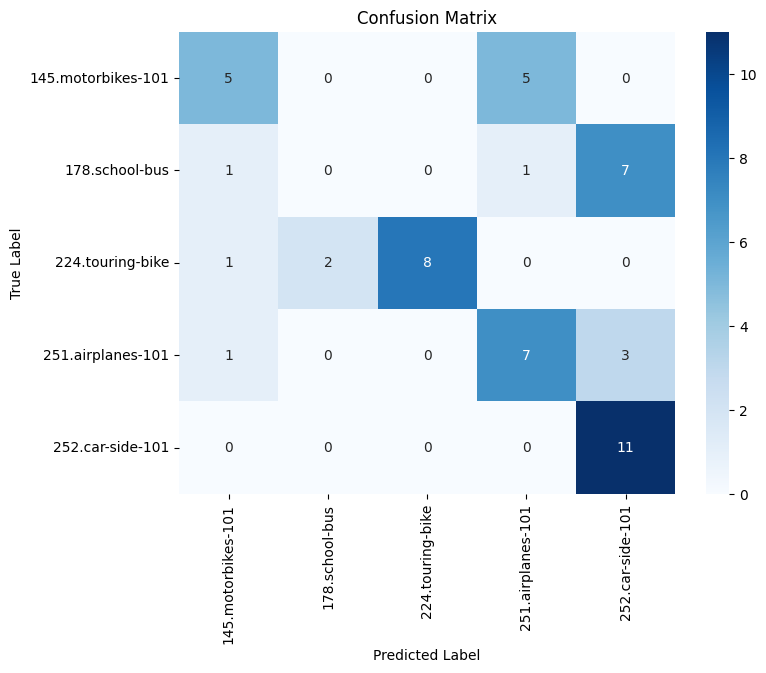

In [10]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


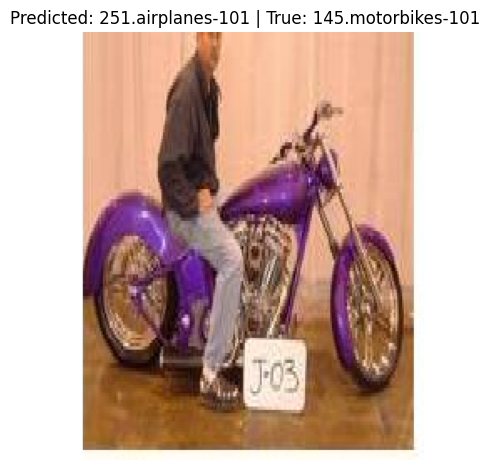

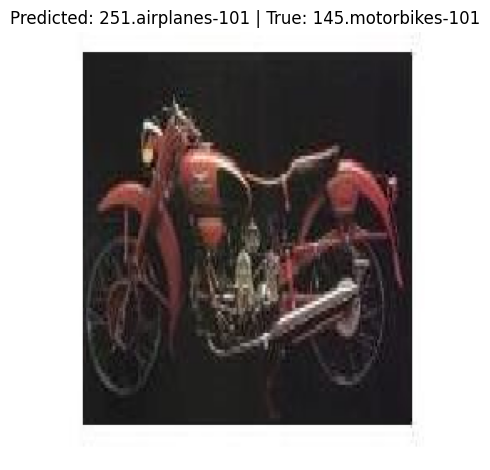

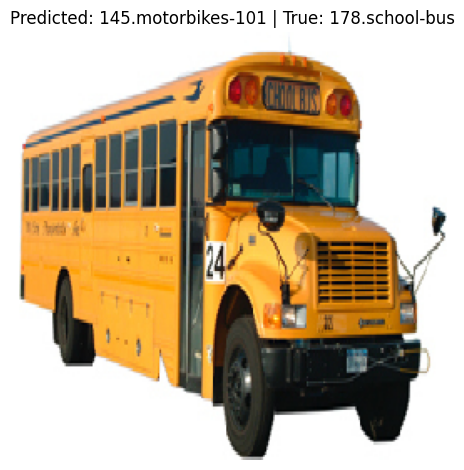

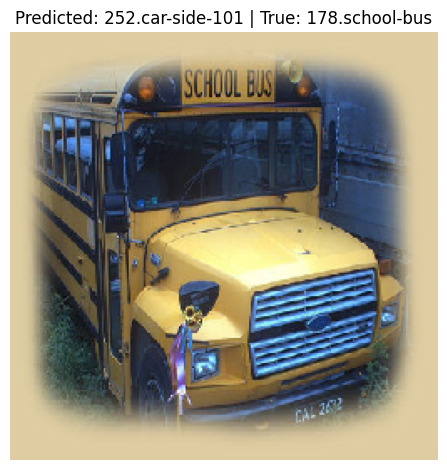

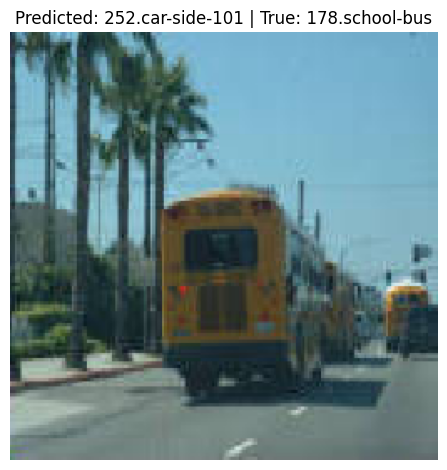

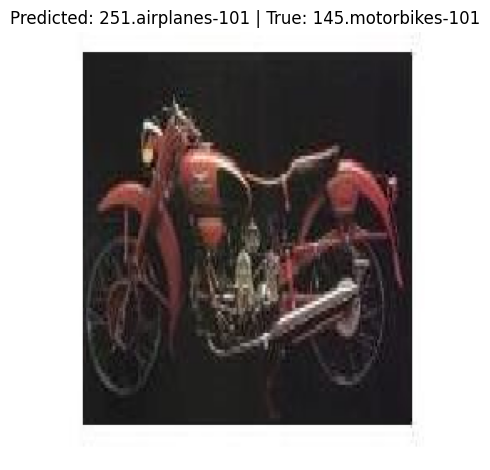

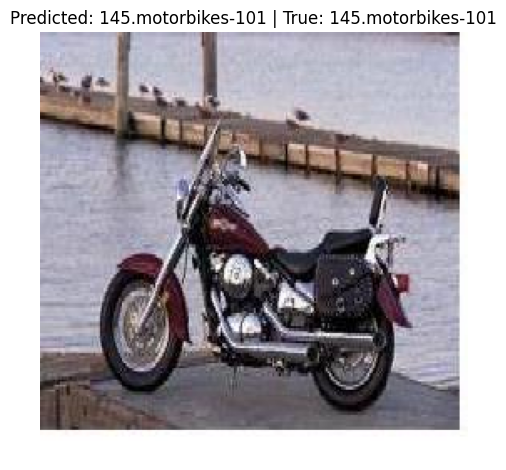

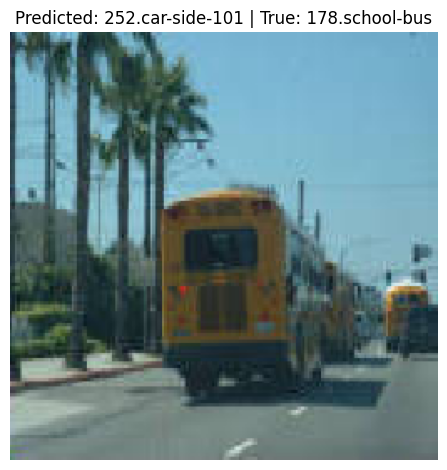

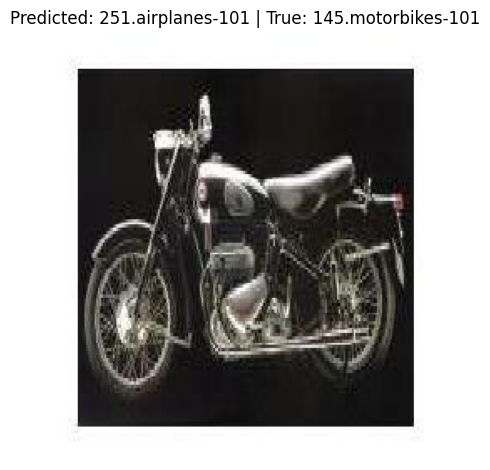

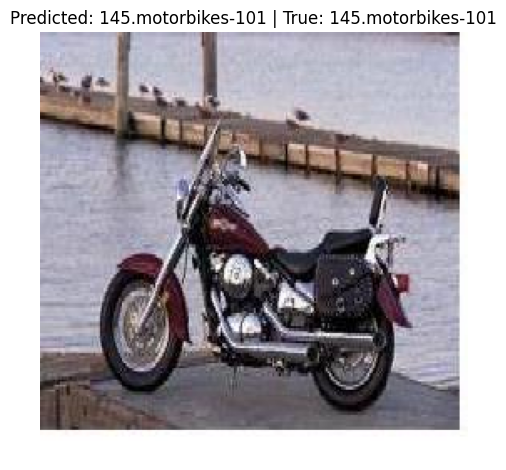

In [11]:
# ====================================================================================
# Sample Prediction Visualization
# ====================================================================================
# This block selects 10 random images from the test set, predicts their labels using
# the trained CNN model, and displays them alongside their true labels. It provides
# a qualitative understanding of how well the model performs on unseen data.
# ====================================================================================

import matplotlib.pyplot as plt
import numpy as np
import random

# Get one full batch of test images and true labels
images, labels = next(test_generator)

# Predict classes using the trained model
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Get class name mapping
class_names = list(test_generator.class_indices.keys())

# Display 10 random test images with predicted vs. true label
for i in range(10):
    idx = random.randint(0, len(images) - 1)

    plt.imshow(images[idx])
    plt.title(f"Predicted: {class_names[predicted_classes[idx]]} | True: {class_names[int(labels[idx])]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
